In [1]:
import numpy as np
import matplotlib.pyplot as plt


from convert_cpp2python import read_cpp_into_floats

plt.rcParams.update({'font.size': 14})

### read in constants from .hpp files
CONSTS, notfloats = read_cpp_into_floats("./constants.hpp")
INITS, notfloats2 = read_cpp_into_floats("./init.hpp") 
MCONSTS = {}
MCONSTS["RGAS_DRY"]   = CONSTS["RGAS_UNIV"]/CONSTS["MR_DRY"]
MCONSTS["RGAS_V"]     = CONSTS["RGAS_UNIV"]/CONSTS["MR_WATER"]
MCONSTS["RHO0"]       = CONSTS["P0"]/MCONSTS["RGAS_DRY"]*CONSTS["TEMP0"] 
MCONSTS["CP0"]        = CONSTS["CP_DRY"]                
MCONSTS["MR0"]        = CONSTS["MR_DRY"]  
MCONSTS["Mr_ratio"]     = CONSTS["MR_WATER"]/CONSTS["MR_DRY"]

print("---- Additional Constants Derived -----")
for c in MCONSTS:
  print(c, "=", MCONSTS[c])
nsupers = INITS["nsupers"] = int(INITS["nsupers"])
print("---------------------------------------------")


---- Constants read from  ./constants.hpp -----
G = 9.80665
RGAS_UNIV = 8.314462618
MR_WATER = 0.01801528
MR_DRY = 0.0289647
LATENT_V = 2437300.0
CP_DRY = 1004.9
CP_V = 1864.0
C_L = 4180.0
RHO_DRY = 1.177
RHO_L = 1000.0
e = 1000.0
RHO_SOL = 2200.0
MR_SOL = 0.058443
IONIC = 2.0
W0 = 0.5
TIME0 = 4000.0
P0 = 100000.0
TEMP0 = 273.15
R0 = 1e-06
L0 = 100.0
EPS0 = 100.0
---------------------------------------------
---- Not floats read from  ./constants.hpp -----
RGAS_DRY = RGAS_UNIV/MR_DRY
RGAS_V = RGAS_UNIV/MR_WATER
DYNVISC = 18.45*1e-6
LATENT_RGAS_V = LATENT_V/RGAS_V
RHO0 = P0/(DC::RGAS_DRY*TEMP0)
CP0 = DC::CP_DRY
MR0 = DC::MR_DRY
F0 = TIME0/(RHO0*R0*R0)
Mr_ratio = DC::MR_WATER/DC::MR_DRY
Cp_dry = DC::CP_DRY / CP0
Cp_v = DC::CP_V / CP0
C_l = DC::C_L / CP0
Latent_v = DC::LATENT_V/(TEMP0*CP0)
Rgas_dry = DC::RGAS_DRY/CP0
Rho_dry = DC::RHO_DRY/RHO0
Rho_l = DC::RHO_L/RHO0
Rho_sol = DC::RHO_SOL/RHO0
Mr_sol = DC::MR_SOL/MR0
IONIC = DC::IONIC
---------------------------------------------
---- Cons

In [2]:
### Helper Functions 

def saturation_pressure(T):
  ''' Calculate the equilibrium vapor pressure 
  of water over liquid water ie. the
  saturation pressure (psat [Pa]). Equation taken from
  typhon.physics.thermodynamics.e_eq_water_mk.'''
  
  if np.any(T <= 0):
      err = 'T must be larger than 0K.'
      raise ValueError(err)

  lnpsat = (54.842763                    # ln(psat) [Pa]
        - 6763.22 / T
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

  return np.exp(lnpsat)               # psat [Pa]



def dry_pot_temp(Temp, P, qv):
    ''' calculate potential Temperature [K]
    assuming moist (unsaturated) air with
    vapour content qv '''
   
    Cpdry = CONSTS["CP_DRY"]
    Cpv = CONSTS["CP_V"]
    Rgasdry = MCONSTS["RGAS_DRY"]
    Rgasv = MCONSTS["RGAS_V"]

    Cp =  Cpdry * (1+qv*Cpv/Cpdry)/(1+qv)
    Rgas = Rgasdry *(1+qv*Rgasv/Rgasdry)/(1+qv)
    
    Theta = Temp*(P[0]/P)**(Rgas/Cp)
    
    return Theta



In [3]:
#### Load data from .csv files ###
with open("sundials2_sol.csv") as file_name:
    t, p, temp, qv, qc = np.loadtxt(file_name, delimiter=",", comments="/*", unpack=True)

with open("sundials2_SDsol.csv") as file_name:
    drops = np.loadtxt(file_name, delimiter=",", comments="/*", unpack=False)
eps = drops[:,0:nsupers]
r = drops[:,nsupers:2*nsupers]
m_sol = drops[:,2*nsupers:]

print("--- Data Shapes ---")
print(t.shape, temp.shape, p.shape, qv.shape, qc.shape)
print(eps.shape, r.shape, m_sol.shape)
print("\n--- Non Dimensional Max/Mins of Data ---")
print("time:", np.amax(t), np.amin(t))
print("p:", np.amax(p), np.amin(p))
print("temp:", np.amax(temp), np.amin(temp))
print("qv, qc", (np.amax(qv), np.amax(qc)), (np.amin(qv), np.amin(qc)))
print("droplet r:", np.amax(r), np.amin(r))




--- Data Shapes ---
(2001,) (2001,) (2001,) (2001,) (2001,)
(2001, 20) (2001, 20) (2001, 20)

--- Non Dimensional Max/Mins of Data ---
time: 0.999999999999918 0.0
p: 1.0 0.774144648884769
temp: 1.00949459522329 0.943915129705088
qv, qc (0.00228934479239319, 0.00168986007622881) (0.000599484716164375, 0.0)
droplet r: 100.184451236506 12.8881926372635


In [4]:
#### RE-Dimensionalise Solution ###
w = INITS["iW"]
t = CONSTS["TIME0"] * t
z = t*w
p, temp = CONSTS["P0"]*p, CONSTS["TEMP0"]*temp
r = CONSTS["R0"]*r

### Some derived quantities
theta = dry_pot_temp(temp, p, qv)                      # parcel potential temp
# gamma = (MCONSTS["RGAS_DRY"]/CONSTS["CP_DRY"]) 
# dry_adia = temp[0]*(p/p[0])**gamma            # dry adiabatic temp
# dry_adia_theta = dry_adia*(p[0]/p)**gamma    # dry adiabatic theta (=const)

pv = qv*p/(MCONSTS["Mr_ratio"] + qv) 
psat = saturation_pressure(temp)
relh = pv/psat
qsat = MCONSTS["Mr_ratio"] * psat/(p-pv) 
s = qv/qsat - 1   


TypeError: logr_distribution() missing 1 required positional argument: 'rspan'

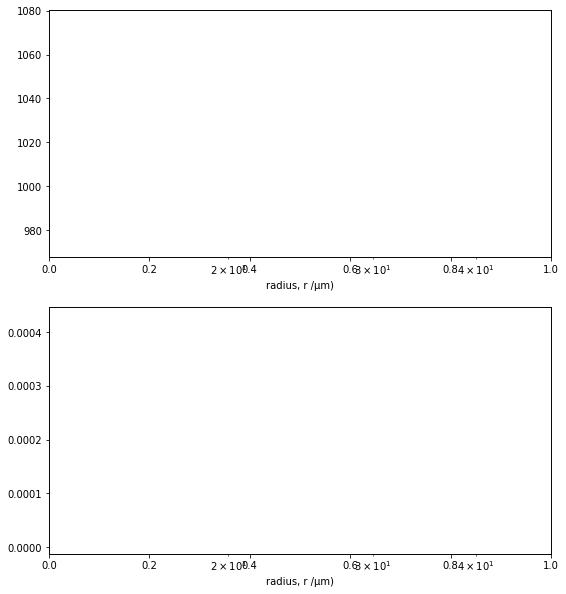

In [6]:
def gaussian_kernel_smoothing(hist, hcens, sig):

    for h in range(len(hist)):
        kernel = 1/(np.sqrt(2*np.pi)*sig)*np.exp(-(hcens - hcens[h])**2/(2*sig**2))
        kernel = kernel/np.sum(kernel)
        hist[h] = np.sum(hist*kernel)  

    hist = np.where(hist<1e-16, 0, hist)  

    return hist, hcens





def logr_distribution(ax, data, freq, rspan, nbins, xlab=True, ylab=None,
    step=False, lab=None, c='k', perlnR=False, smooth=False):
    ''' plot distribution of data against logr using histogram to
    get frequency of a particular value of data thta falls in 
    range lnr -> lnr + dlnr '''

    hedgs = np.linspace(np.log(rspan[0]), np.log(rspan[1]), nbins+1)             # edges to lnr bins
    hwdths = hedgs[1:]- hedgs[:-1]                               # lnr bin widths
    hcens = (hedgs[1:]+hedgs[:-1])/2                             # lnr bin centres

    if perlnR == False: #get number frequency in each bin
        hist, hedgs = np.histogram(data, bins=hedgs, weights=freq, density=False)
    else: #get frequencies / bin width
        hist, hedgs = np.histogram(data, bins=hedgs, weights=freq, density=False)
        hist = hist/hwdths

    if smooth:
        hist, hcens = gaussian_kernel_smoothing(hist, hcens, smooth)


    if ax:
        if step:
            ax.step(hcens, hist, label=lab, where='mid', color=c)
        else:
            ax.bar(hcens, hist, hwdths, label=lab, color=c)

        ax.legend()
        ax.set_ylabel(ylab)
        if xlab:
            ax.set_xlabel('ln(r /\u03BCm)')
            ax.xaxis.tick_top() 
            ax.xaxis.set_label_position('top')
        else:
            ax.set_xticks([])

    return hist, hedgs
  
  
def linear_twinax(ax, lnr, eps):
    ''' linear x axis for lognormal 
    radius distribution plots'''
     
    axb = ax.twiny()
   
    axb.plot(np.e**lnr*1e6, eps, alpha=0)
    axb.set_xscale('log')
    axb.set_xlabel('radius, r /\u03BCm)')

    axb.xaxis.tick_bottom() 
    axb.xaxis.set_label_position('bottom') 

    return axb



fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(9,10))
nbins = 300
rspan = [np.amin(r), np.amax(r)]
nplts = 3
tplt = np.linspace(t[0], t[-1], nplts)
#tplt = np.linspace(1650, 1750, nplts)
#tplt = [t[0]]

linear_twinax(ax1, np.log(r[0,:]), eps[0,:])
mass0 = CONSTS["RHO_L"]*4*np.pi/3*(r[0,:]**3)*1000
linear_twinax(ax2, np.log(r[0,:]), eps[0,:]*mass0)
for i in range(nplts):
    ind = np.argmin(abs(t-tplt[i]))
    tlab = 't = {:.2f}s'.format(t[ind])
    c = 'C'+str(i)
    logr_distribution(ax1, r[ind,:], eps[ind,:], rspan, nbins=nbins,
            ylab='Droplet Conc. [m$^{-3}$]', step=True, 
            lab=tlab, c='C'+str(i), smooth=0.1)
    mass = CONSTS["RHO_L"]*4*np.pi/3*(r[ind,:]**3)*1000
    logr_distribution(ax2, r[ind,:], eps[ind,:]*mass, rspan, nbins=nbins,
            xlab=False, ylab='Mass Density Distribution [g/m$^{3}$/unit lnR]', 
            step=True, lab=tlab, c='C'+str(i), perlnR=True, smooth=0.05)
#ax1.set_yscale('log')
#ax2.set_yscale('log')
plt.tight_layout()



